In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops,hog
import albumentations as A
import glob
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.pipeline import Pipeline
from natsort import natsorted
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, StackingClassifier, VotingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

feature_names=[]

c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def augment_image(image, image_bg):
    image_bg = cv2.resize(image_bg, (image.shape[1], image.shape[0]))  # Resize v·ªÅ c√πng k√≠ch th∆∞·ªõc

    transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.3),
], p=1.0, additional_targets={"image_bg": "image"})

    augmented = transform(image=image, image_bg=image_bg)
    return augmented["image"], augmented["image_bg"]

def apply_gabor(img, ksize=31, sigma=5, lambd=10, gamma=0.5, psi=0):
    """√Åp d·ª•ng b·ªô l·ªçc Gabor l√™n ·∫£nh."""
    theta_vals = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 4 h∆∞·ªõng ch√≠nh
    features = []
    
    for theta in theta_vals:
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi)
        filtered_img = cv2.filter2D(img, cv2.CV_32F, kernel)
        features.append(np.mean(filtered_img))  # L·∫•y gi√° tr·ªã trung b√¨nh
    
    return np.array(features)

def extract_gist_custom(image, grid_size=4):
    """Tr√≠ch xu·∫•t ƒë·∫∑c tr∆∞ng GIST b·∫±ng Gabor Filter + Fourier Transform t·ª´ ·∫£nh ƒë√£ ƒë·ªçc."""
    # img = cv2.resize(image, (256, 256))  # Resize v·ªÅ k√≠ch th∆∞·ªõc c·ªë ƒë·ªãnh
    img=image
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Chuy·ªÉn v·ªÅ grayscale n·∫øu c·∫ßn

    h, w = img.shape
    cell_h, cell_w = h // grid_size, w // grid_size
    gist_features = []

    for i in range(grid_size):
        for j in range(grid_size):
            cell = img[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
            gabor_features = apply_gabor(cell)
            gist_features.extend(gabor_features)
    
    return np.array(gist_features)

def extract_glcm_features_from_masked(image, mask, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    

    masked_gray = cv2.bitwise_and(gray, gray, mask=mask)
    coords = np.column_stack(np.where(mask > 0))
    
    if coords.shape[0] == 0:
        return np.zeros(5 * len(distances) * len(angles))  

    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    cropped_gray = masked_gray[x_min:x_max+1, y_min:y_max+1]

    # Ki·ªÉm tra k√≠ch th∆∞·ªõc h·ª£p l·ªá
    if cropped_gray.size < 2:
        return np.zeros(5 * len(distances) * len(angles))

    # ƒê·∫£m b·∫£o ki·ªÉu d·ªØ li·ªáu l√† uint8
    cropped_gray = cropped_gray.astype(np.uint8)

    glcm = graycomatrix(cropped_gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    feature_values = [graycoprops(glcm, prop).flatten() for prop in properties]

    features = np.hstack(feature_values).flatten()  
    expected_length = 5 * len(distances) * len(angles)  
    if len(features) != expected_length:
        features = np.pad(features, (0, expected_length - len(features)))  
    
    return features


def extract_sift_features(image, mask):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    sift = cv2.SIFT_create()  # Ch·ªâ l·∫•y t·ªëi ƒëa keypoints
    keypoints, descriptors = sift.detectAndCompute(gray, mask)

    if descriptors is None:
        return np.zeros(128)  # N·∫øu kh√¥ng c√≥ keypoints, tr·∫£ v·ªÅ vector 128-d to√†n 0
    
    # L·∫•y trung b√¨nh t·∫•t c·∫£ c√°c keypoint descriptors
    sift_features = np.mean(descriptors, axis=0)  # (128,)

    return sift_features  # ƒê·∫£m b·∫£o lu√¥n c√≥ shape (128,)










def extract_lbp_features(gray, mask, P=8, R=1):
    """Tr√≠ch xu·∫•t LBP ch·ªâ trong v√πng mask."""
    global feature_names
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    lbp_masked = lbp[mask == 255]  # Ch·ªâ l·∫•y pixel trong v√πng mask

    # T·∫°o histogram t·ª´ LBP trong v√πng n·∫•m
    hist, _ = np.histogram(lbp_masked, bins=np.arange(0, P+3), density=True)
    feature_names += [f'LBP_{i}' for i in range(len(hist))]
    return hist

def extract_color_histogram(image, bins=(8, 8, 8), mask=None):
    global feature_names
    if mask is not None:
        mask = mask.astype(np.uint8)

    # Chuy·ªÉn bins v·ªÅ d·∫°ng tuple to√†n s·ªë nguy√™n
    bins = tuple(map(int, bins))  

    # Ki·ªÉm tra mask c√≥ h·ª£p l·ªá kh√¥ng
    if mask is not None and (mask.dtype != np.uint8 or mask.shape[:2] != image.shape[:2]):
        raise ValueError("Mask must be a grayscale image (uint8) with the same width and height as the image.")

    # Chuy·ªÉn ƒë·ªïi kh√¥ng gian m√†u
    # lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    bgr = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # T√≠nh histogram
    # hist_lab = cv2.calcHist([lab], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256]).flatten()
    hist_hsv = cv2.calcHist([hsv], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256]).flatten()
    hist_bgr = cv2.calcHist([bgr], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256]).flatten()

    
    # feature_names += [f"lab_hist_{i}" for i in range(len(hist_lab))]
    feature_names += [f"hsv_hist_{i}" for i in range(len(hist_hsv))]
    feature_names += [f"bgr_hist_{i}" for i in range(len(hist_bgr))]

    # return np.hstack([hist_lab, hist_hsv, hist_bgr])
    return np.hstack([ hist_hsv, hist_bgr])

    # return np.hstack([hist_lab, hist_hsv])




def extract_contour_features(image):
    global feature_names
    
    # Ki·ªÉm tra ·∫£nh ƒë·∫ßu v√†o
    # if image is None or len(image.shape) != 3:
    #     return np.zeros(5, dtype=np.float32), None
    # plt.imshow(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.uint8(gray)
    # plt.imshow(gray)
    # plt.show()
    # L√†m m·ªãn ·∫£nh
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive threshold
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Lo·∫°i b·ªè nhi·ªÖu
    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # T√¨m contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # N·∫øu kh√¥ng t√¨m th·∫•y contour n√†o, tr·∫£ v·ªÅ gi√° tr·ªã r·ªóng
    if not contours:
        return np.zeros(5, dtype=np.float32), np.zeros_like(gray, dtype=np.uint8)

    # L·ªçc contour l·ªõn nh·∫•t c√≥ di·ªán t√≠ch > 500 pixels
    largest_contour = max(contours, key=cv2.contourArea, default=None)
    if largest_contour is None or cv2.contourArea(largest_contour) < 500:
        return np.zeros(5, dtype=np.float32), np.zeros_like(gray, dtype=np.uint8)

    # T·∫°o mask t·ª´ contour
    mask = np.zeros_like(gray, dtype=np.uint8)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # T√≠nh ƒë·∫∑c tr∆∞ng
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    compactness = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0
    x, y, w, h = cv2.boundingRect(largest_contour)
    aspect_ratio = w / h if h != 0 else 0
    num_contours = len(contours)

    feature_names += ["contour_area", "contour_perimeter", "compactness", "aspect_ratio", "num_contours"]
    
    return np.array([area, perimeter, compactness, aspect_ratio, num_contours], dtype=np.float32), mask





def extract_orb_mean_descriptor(image,mask):
    """ Tr√≠ch xu·∫•t ƒë·∫∑c tr∆∞ng ORB v√† t√≠nh trung b√¨nh c·ªßa descriptors """
    orb = cv2.ORB_create()
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = orb.detectAndCompute(gray, mask)
    
    if descriptors is not None:
        mean_descriptor = np.mean(descriptors, axis=0)  # L·∫•y trung b√¨nh theo t·ª´ng c·ªôt
    else:
        mean_descriptor = np.zeros(32, dtype=np.float32)  # N·∫øu kh√¥ng c√≥ keypoints
    
    return mean_descriptor




def extract_hu_moments(image, mask):
    global feature_names
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    masked_gray = cv2.bitwise_and(gray, gray, mask=mask)  # Ch·ªâ gi·ªØ l·∫°i v√πng contour

    moments = cv2.moments(masked_gray)
    hu_moments = cv2.HuMoments(moments).flatten()

    feature_names += [f"hu_moments_{i+1}" for i in range(len(hu_moments))]


    return -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)


In [3]:

def extract_basic_color(image,mask):
    def mean_std_color(image, mask=None):
        """T√≠nh trung b√¨nh v√† ƒë·ªô l·ªách chu·∫©n c·ªßa t·ª´ng k√™nh m√†u c√≥ mask, tr·∫£ v·ªÅ np.array."""
        masked_img = image if mask is None else image[mask > 0]
        mean_values = np.mean(masked_img, axis=0)
        std_values = np.std(masked_img, axis=0)
        return np.concatenate([mean_values, std_values])

    def dominant_color_ratio(image, mask=None):
        """T√¨m k√™nh m√†u chi·∫øm ∆∞u th·∫ø trong v√πng mask, tr·∫£ v·ªÅ one-hot vector (3 ph·∫ßn t·ª≠)."""
        masked_img = image if mask is None else image[mask > 0]
        mean_values = np.mean(masked_img, axis=0)
        max_channel = np.argmax(mean_values)
        one_hot = np.zeros(3)
        one_hot[max_channel] = 1
        return one_hot

    def sum_color_channels(image, mask=None):
        """T√≠nh t·ªïng s·ªë pixel cho t·ª´ng k√™nh m√†u trong v√πng mask, tr·∫£ v·ªÅ np.array."""
        masked_img = image if mask is None else image[mask > 0]
        return np.sum(masked_img, axis=0)

    def color_ratios(image, mask=None):
        """T√≠nh t·ª∑ l·ªá gi·ªØa c√°c k√™nh m√†u (R/G, G/B, B/R) trong v√πng mask, tr·∫£ v·ªÅ np.array."""
        masked_img = image if mask is None else image[mask > 0]
        b, g, r = masked_img[:, 0], masked_img[:, 1], masked_img[:, 2]
        ratio_rg = np.mean(r) / (np.mean(g) + 1e-6)  # Tr√°nh chia cho 0
        ratio_gb = np.mean(g) / (np.mean(b) + 1e-6)
        ratio_br = np.mean(b) / (np.mean(r) + 1e-6)
        return np.array([ratio_rg, ratio_gb, ratio_br])

 
    features = np.concatenate([
        mean_std_color(image, mask),
        dominant_color_ratio(image, mask),
        sum_color_channels(image, mask),
        color_ratios(image, mask),
    ])

    return features


# Load data

In [4]:
train_dir = r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\15class_train_test\train"
test_dir = r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\15class_train_test\test"

# L·∫•y danh s√°ch ƒë∆∞·ªùng d·∫´n ·∫£nh v√† nh√£n
X_train_paths = natsorted(glob.glob(os.path.join(train_dir, "*/*.jpg")))
X_test_paths = natsorted(glob.glob(os.path.join(test_dir, "*/*.jpg")))

# L·∫•y nh√£n t·ª´ t√™n th∆∞ m·ª•c cha
y_train_labels = [os.path.basename(os.path.dirname(path)) for path in X_train_paths]
y_test_labels = [os.path.basename(os.path.dirname(path)) for path in X_test_paths]

# Ki·ªÉm tra k·∫øt qu·∫£
print(f"Train size: {len(X_train_paths)}, Test size: {len(X_test_paths)}")

Train size: 3810, Test size: 954


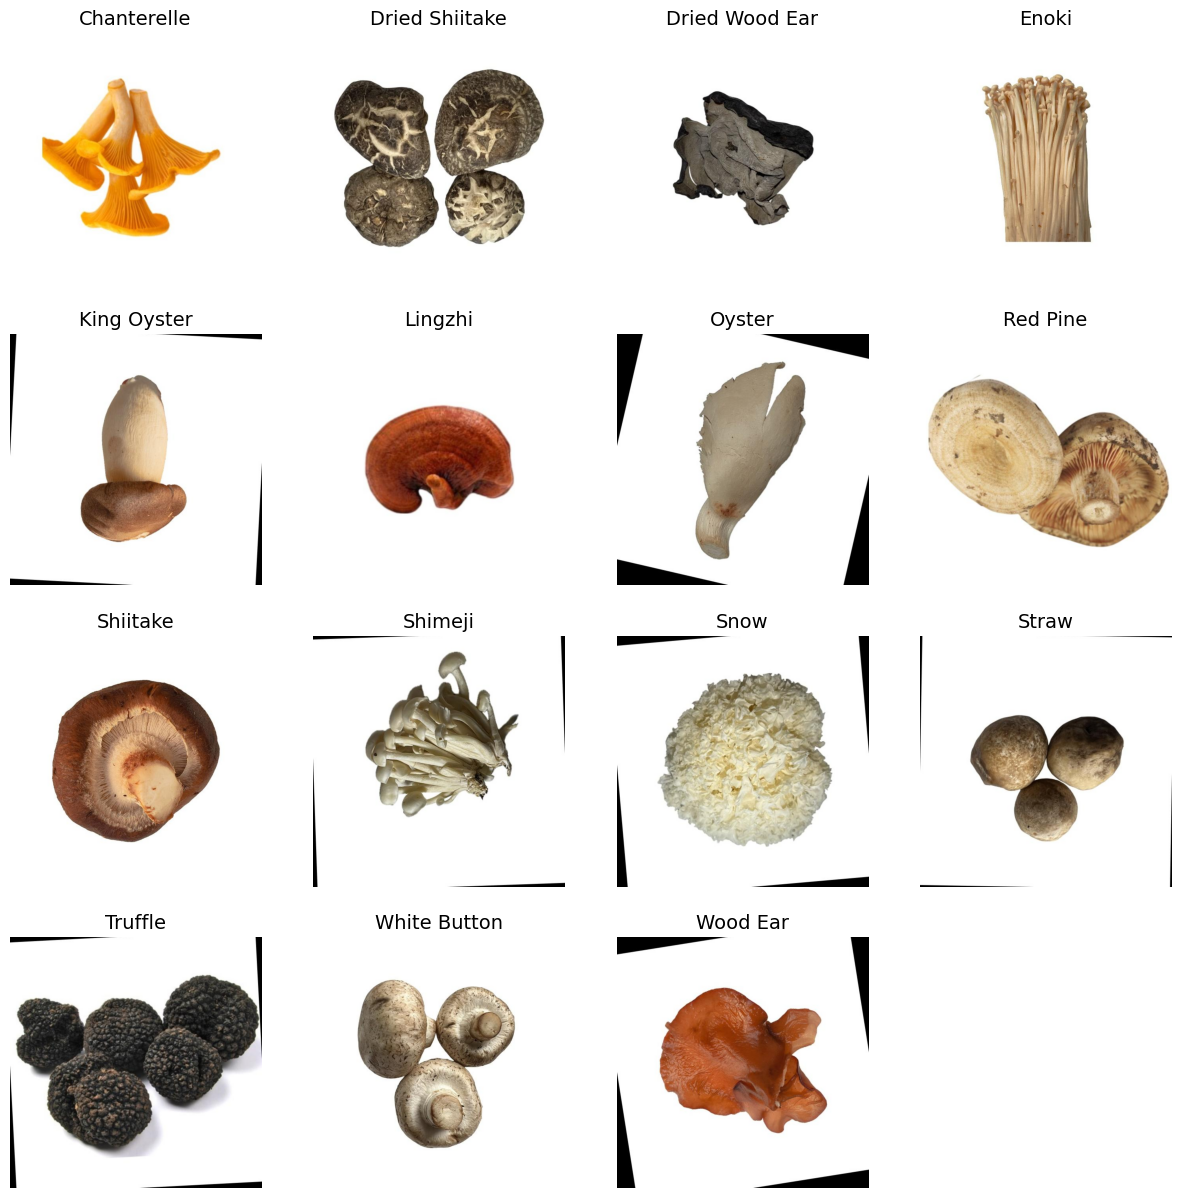

In [6]:
import random

plt.figure(figsize=(15, 15))  # Set the figure size

# L·∫•y danh s√°ch c√°c lo·∫°i n·∫•m duy nh·∫•t
unique_labels = list(set(y_train_labels))

# T·∫°o m·ªôt t·ª´ ƒëi·ªÉn ƒë·ªÉ l∆∞u tr·ªØ h√¨nh ·∫£nh ƒë·∫ßu ti√™n c·ªßa m·ªói lo·∫°i n·∫•m
first_images = {}

# Duy·ªát qua c√°c ƒë∆∞·ªùng d·∫´n ·∫£nh v√† nh√£n t∆∞∆°ng ·ª©ng
for img_path, label in zip(X_train_paths, y_train_labels):
    if label not in first_images:
        first_images[label] = img_path

# Hi·ªÉn th·ªã h√¨nh ·∫£nh ƒë·∫ßu ti√™n c·ªßa m·ªói lo·∫°i n·∫•m
# Randomly select an image for each label
for label in unique_labels:
    first_images[label] = random.choice([img_path for img_path, lbl in zip(X_train_paths, y_train_labels) if lbl == label])

# Display the randomly selected images
for idx, (label, img_path) in enumerate(first_images.items()):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
    
    plt.subplot(4, 4, idx + 1)  # Create a grid of subplots
    plt.imshow(image)
    plt.title(label, fontsize=14)  # Add the label as the title with larger font size
    plt.axis('off')

plt.show()

# H√†m v·∫≠n h√†nh tr√≠ch xu·∫•t feature

In [5]:
feature_names = ["color_hist", "hu_moments", "lbp", "glcm", "contour", "sift", "gist", "color_basic", "orb"]
# class_counts = Counter(labels)

# # ƒê·ªãnh nghƒ©a ng∆∞·ª°ng s·ªë l∆∞·ª£ng ·∫£nh t·ªëi thi·ªÉu, v√≠ d·ª• 300
# THRESHOLD = 700
def extract_features(image_paths, labels, augment=False, save_path="features.npz"):
    feature_dict = {feat: [] for feat in feature_names}
    y = []
    
    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Extracting Features"):
        image = cv2.imread(path)    
        # original_image = cv2.imread(image_mapping[path])
        
        # h, w = image.shape[:2]
        # scale=0.5
        # image=cv2.resize(image,(int(w * scale), int(h * scale)))
        original_image=image
        if image is None:
            continue

        # Tr√≠ch xu·∫•t ƒë·∫∑c tr∆∞ng t·ª´ ·∫£nh g·ªëc
        contour_feat, mask = extract_contour_features(image)
        
        features = {
            "color_hist": extract_color_histogram(image, bins=[8, 8, 8], mask=mask),
            "hu_moments": extract_hu_moments(image, mask),
            "lbp": extract_lbp_features(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), mask),
            "glcm": extract_glcm_features_from_masked(image, mask),
            "contour": contour_feat,
            "sift": extract_sift_features(image, mask),
            "gist": extract_gist_custom(original_image),
            "color_basic": extract_basic_color(image, mask),
            "orb": extract_orb_mean_descriptor(image, mask)
        }

        for key, value in features.items():
            feature_dict[key].append(value)
        y.append(label)
      
        # Augmentation (n·∫øu c·∫ßn)
        if augment:
            aug_img, aug_original_img = augment_image(image, original_image)
            contour_feat, mask = extract_contour_features(aug_img)

            
            aug_features = {
                "color_hist": extract_color_histogram(aug_img, bins=[8, 8, 8], mask=mask),
                "hu_moments": extract_hu_moments(aug_img, mask),
                "lbp": extract_lbp_features(cv2.cvtColor(aug_img, cv2.COLOR_BGR2GRAY), mask),
                "glcm": extract_glcm_features_from_masked(aug_img, mask),
                "contour": contour_feat,
                "sift": extract_sift_features(aug_img, mask),
                "gist": extract_gist_custom(aug_original_img),
                "color_basic": extract_basic_color(aug_img, mask),
                "orb": extract_orb_mean_descriptor(aug_img, mask)
            }

            

            for key, value in aug_features.items():
                feature_dict[key].append(value)
            y.append(label)

    # Chuy·ªÉn danh s√°ch th√†nh m·∫£ng NumPy
    feature_dict = {key: np.array(value) for key, value in feature_dict.items()}
    y = np.array(y)

    # üî• **L∆∞u feature v√†o file .npz**
    # np.savez(save_path, **feature_dict, labels=y)
    # print(f"‚úÖ Features saved to {save_path}")

    return feature_dict, y

def combine_features(feature_dict, selected_features):
    feature_list = [np.array(feature_dict[feat]) for feat in selected_features]
    return np.hstack(feature_list)


# B·∫Øt ƒë·∫ßu tr√≠ch xu·∫•t

In [6]:
# Tr√≠ch xu·∫•t v√† l∆∞u ƒë·∫∑c tr∆∞ng cho t·∫≠p train
feature_dict_train, y_train = extract_features(X_train_paths, y_train_labels, augment=False, save_path="features_train.npz")

# Tr√≠ch xu·∫•t v√† l∆∞u ƒë·∫∑c tr∆∞ng cho t·∫≠p test
feature_dict_test, y_test = extract_features(X_test_paths, y_test_labels, augment=False, save_path="features_test.npz")



Extracting Features: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 954/954 [02:47<00:00,  5.70it/s]


In [ ]:

def check_nan_inf(feature_dict):
    for key, features in feature_dict.items():
        if np.isnan(features).any():
            print(f"‚ö† C·∫£nh b√°o: ·∫¢nh {key} c√≥ gi√° tr·ªã NaN!")
        if np.isinf(features).any():
            print(f"‚ö† C·∫£nh b√°o: ·∫¢nh {key} c√≥ gi√° tr·ªã v√¥ c·ª±c!")

check_nan_inf(feature_dict_train)
check_nan_inf(feature_dict_test)


‚ö† C·∫£nh b√°o: ·∫¢nh lbp c√≥ gi√° tr·ªã NaN!


In [9]:
train_counts = Counter(y_train_labels)
test_counts = Counter(y_test_labels)

print("Train class distribution:")
for label, count in train_counts.items():
    print(f"{label}: {count}")

print("\nTest class distribution:")
for label, count in test_counts.items():
    print(f"{label}: {count}")

Train class distribution:
Chanterelle: 77
Dried Shiitake: 295
Dried Wood Ear: 336
Enoki: 296
King Oyster: 224
Lingzhi: 168
Oyster: 296
Red Pine: 184
Shiitake: 360
Shimeji: 288
Snow: 224
Straw: 352
Truffle: 128
White Button: 326
Wood Ear: 256

Test class distribution:
Chanterelle: 18
Dried Shiitake: 76
Dried Wood Ear: 85
Enoki: 71
King Oyster: 55
Lingzhi: 42
Oyster: 79
Red Pine: 47
Shiitake: 89
Shimeji: 73
Snow: 50
Straw: 92
Truffle: 34
White Button: 82
Wood Ear: 61


# Th·ª≠ t·ªï h·ª£p


In [7]:
# from itertools import combinations
# best_acc = 0
# best_features = None
# selected_features = [ "lbp", "gist", "glcm","hu_moments", "color_basic", "orb"]
# for r in range(2, len(selected_features) +1):
# # for r in range(1, 2):
#     for subset in combinations(selected_features, r):
#         subset = ["color_hist", "sift"]+ list(subset)

        
#         # K·∫øt h·ª£p feature
#         X_train_sub = combine_features(feature_dict_train, subset)
#         X_test_sub = combine_features(feature_dict_test, subset)
        
#         # Chu·∫©n h√≥a d·ªØ li·ªáu
#         pipeline = Pipeline([
#             ("imputer", SimpleImputer(strategy="mean")),
#             ("scaler", StandardScaler())
#         ])
#         X_train_sub = pipeline.fit_transform(X_train_sub)
#         X_test_sub = pipeline.transform(X_test_sub)
        
#         # Train model
#         model = lgb.LGBMClassifier(
#             num_leaves=31,
#             learning_rate=0.03,
#             n_estimators=300,
#             reg_alpha=0.1,
#             reg_lambda=0.1,
#             class_weight='balanced',
#             verbosity=-1
#         )
#         model.fit(X_train_sub, y_train)
#         y_pred = model.predict(X_test_sub)
#         acc = accuracy_score(y_test, y_pred)
        
#         print(f"Features: {subset} -> Accuracy: {acc:.4f}")
        
#         # L∆∞u t·∫≠p h·ª£p feature t·ªët nh·∫•t
#         if acc > best_acc:
#             best_acc = acc
#             best_features = subset

# print(f"Best feature combination: {best_features} with accuracy {best_acc:.4f}")


# Ch·∫°y ri√™ng model

In [12]:

# K·∫øt h·ª£p c√°c ƒë·∫∑c tr∆∞ng ƒë√£ ch·ªçn
selected_features = ['color_hist', 'sift', 'lbp', 'glcm', 'hu_moments', 'orb']
for feat in selected_features:
    print(f"{feat}: {np.array(feature_dict_train[feat]).shape}")

X_train = combine_features(feature_dict_train, selected_features)
X_test = combine_features(feature_dict_test, selected_features)

# M√£ h√≥a nh√£n
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Chu·∫©n h√≥a d·ªØ li·ªáu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# X·ª≠ l√Ω gi√° tr·ªã thi·∫øu
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# √Åp d·ª•ng SMOTE
# smote = SMOTE(sampling_strategy="auto", random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Ki·ªÉm tra k·∫øt qu·∫£
# print(f"Tr∆∞·ªõc SMOTE: {np.bincount(y_train)}")
# print(f"Sau SMOTE: {np.bincount(y_train_resampled)}")

color_hist: (3810, 1024)
sift: (3810, 128)
lbp: (3810, 10)
glcm: (3810, 20)
hu_moments: (3810, 7)
orb: (3810, 32)


In [18]:
train_counts = Counter(y_train)
test_counts = Counter(y_test)

print("Train class distribution:")
for label, count in train_counts.items():
    print(f"{label}: {count}")

print("\nTest class distribution:")
for label, count in test_counts.items():
    print(f"{label}: {count}")

Train class distribution:
0: 77
1: 295
2: 336
3: 296
4: 224
5: 168
6: 296
7: 184
8: 360
9: 288
10: 224
11: 352
12: 128
13: 326
14: 256

Test class distribution:
0: 18
1: 76
2: 85
3: 71
4: 55
5: 42
6: 79
7: 47
8: 89
9: 73
10: 50
11: 92
12: 34
13: 82
14: 61


In [19]:
unique_labels = np.unique(y_train_labels)  # `y_train_original` l√† d·ªØ li·ªáu tr∆∞·ªõc khi m√£ h√≥a
label_mapping = {i: label for i, label in enumerate(unique_labels)}

print(label_mapping)

{0: 'Chanterelle', 1: 'Dried Shiitake', 2: 'Dried Wood Ear', 3: 'Enoki', 4: 'King Oyster', 5: 'Lingzhi', 6: 'Oyster', 7: 'Red Pine', 8: 'Shiitake', 9: 'Shimeji', 10: 'Snow', 11: 'Straw', 12: 'Truffle', 13: 'White Button', 14: 'Wood Ear'}


In [14]:
X_train.shape

(3810, 1221)

In [9]:


# Train l·∫ßn 1 v·ªõi t·∫•t c·∫£ features ƒë∆∞·ª£c ch·ªçn
lgb_model = lgb.LGBMClassifier(
    num_leaves=31,
    learning_rate=0.03,
    n_estimators=300,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight='balanced'
)


lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
print(f"LGBM Accuracy tr√™n test: {accuracy_score(y_test, y_pred_lgb):.4f}")


feature_importances = lgb_model.feature_importances_


# X√°c ƒë·ªãnh s·ªë chi·ªÅu c·ªßa t·ª´ng nh√≥m ƒë·∫∑c tr∆∞ng
feature_dims = {feat: np.array(feature_dict_train[feat]).shape[1] for feat in selected_features}

# T·∫°o danh s√°ch t√™n chi ti·∫øt cho t·ª´ng feature
feature_names_important = []
for feat in selected_features:
    feature_names_important.extend([f"{feat}_{i}" for i in range(feature_dims[feat])])




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100322
[LightGBM] [Info] Number of data points in the train set: 3810, number of used features: 610
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightG

In [27]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Train LGBM
lgb_model = lgb.LGBMClassifier(
    num_leaves=31,
    learning_rate=0.03,
    n_estimators=300,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight='balanced'
)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
acc_lgb = accuracy_score(y_test, y_pred_lgb)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Train XGBoost
xgb_model = XGBClassifier(n_estimators=300, learning_rate=0.03, reg_alpha=0.1, reg_lambda=0.1, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

# Print results
print(f"LGBM Accuracy: {acc_lgb:.4f}")
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"XGBoost Accuracy: {acc_xgb:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100322
[LightGBM] [Info] Number of data points in the train set: 3810, number of used features: 610
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightG

c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:01:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


LGBM Accuracy: 0.9088
Random Forest Accuracy: 0.9256
XGBoost Accuracy: 0.8857


In [10]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
# Train LGBM
lgb_model = lgb.LGBMClassifier(
    num_leaves=31,
    learning_rate=0.03,
    n_estimators=300,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight='balanced'
)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
acc_lgb = accuracy_score(y_test, y_pred_lgb)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Train XGBoost
xgb_model = XGBClassifier(n_estimators=300, learning_rate=0.03, reg_alpha=0.1, reg_lambda=0.1, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)



# Train Decision Tree (Fastest)
dt_model = DecisionTreeClassifier(class_weight="balanced", random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

# Train Extra Trees
et_model = ExtraTreesClassifier(n_estimators=300, class_weight="balanced", random_state=42)
et_model.fit(X_train, y_train)
y_pred_et = et_model.predict(X_test)
acc_et = accuracy_score(y_test, y_pred_et)

# Train CatBoost (Comparable to XGBoost)
cat_model = CatBoostClassifier(iterations=300, learning_rate=0.03, depth=6, verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
acc_cat = accuracy_score(y_test, y_pred_cat)

# Print results
print(f"Decision Tree Accuracy: {acc_dt:.4f}")
print(f"Extra Trees Accuracy: {acc_et:.4f}")
print(f"CatBoost Accuracy: {acc_cat:.4f}")
print(f"LGBM Accuracy: {acc_lgb:.4f}")
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"XGBoost Accuracy: {acc_xgb:.4f}")




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100322
[LightGBM] [Info] Number of data points in the train set: 3810, number of used features: 610
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightG

c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Decision Tree Accuracy: 0.7254
Extra Trees Accuracy: 0.9308
CatBoost Accuracy: 0.9256
LGBM Accuracy: 0.9088
Random Forest Accuracy: 0.9256
XGBoost Accuracy: 0.8857


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# T√≠nh c√°c ch·ªâ s·ªë ƒë√°nh gi√°
results = {
    "Model": ["LGBM", "Random Forest", "XGBoost", "Decision Tree", "Extra Trees", "CatBoost"],
    "Accuracy": [acc_lgb, acc_rf, acc_xgb, acc_dt, acc_et, acc_cat],
    "Precision": [
        precision_score(y_test, y_pred_lgb, average="weighted"),
        precision_score(y_test, y_pred_rf, average="weighted"),
        precision_score(y_test, y_pred_xgb, average="weighted"),
        precision_score(y_test, y_pred_dt, average="weighted"),
        precision_score(y_test, y_pred_et, average="weighted"),
        precision_score(y_test, y_pred_cat, average="weighted"),
    ],
    "Recall": [
        recall_score(y_test, y_pred_lgb, average="weighted"),
        recall_score(y_test, y_pred_rf, average="weighted"),
        recall_score(y_test, y_pred_xgb, average="weighted"),
        recall_score(y_test, y_pred_dt, average="weighted"),
        recall_score(y_test, y_pred_et, average="weighted"),
        recall_score(y_test, y_pred_cat, average="weighted"),
    ],
    "F1-score": [
        f1_score(y_test, y_pred_lgb, average="weighted"),
        f1_score(y_test, y_pred_rf, average="weighted"),
        f1_score(y_test, y_pred_xgb, average="weighted"),
        f1_score(y_test, y_pred_dt, average="weighted"),
        f1_score(y_test, y_pred_et, average="weighted"),
        f1_score(y_test, y_pred_cat, average="weighted"),
    ],
}

# Chuy·ªÉn k·∫øt qu·∫£ th√†nh DataFrame
df_results = pd.DataFrame(results)
print(df_results.to_latex(index=False, float_format="%.4f"))


\begin{tabular}{lrrrr}
\toprule
Model & Accuracy & Precision & Recall & F1-score \\
\midrule
LGBM & 0.9088 & 0.9098 & 0.9088 & 0.9071 \\
Random Forest & 0.9256 & 0.9318 & 0.9256 & 0.9249 \\
XGBoost & 0.8857 & 0.8896 & 0.8857 & 0.8850 \\
Decision Tree & 0.7254 & 0.7697 & 0.7254 & 0.7249 \\
Extra Trees & 0.9308 & 0.9345 & 0.9308 & 0.9303 \\
CatBoost & 0.9256 & 0.9298 & 0.9256 & 0.9246 \\
\bottomrule
\end{tabular}



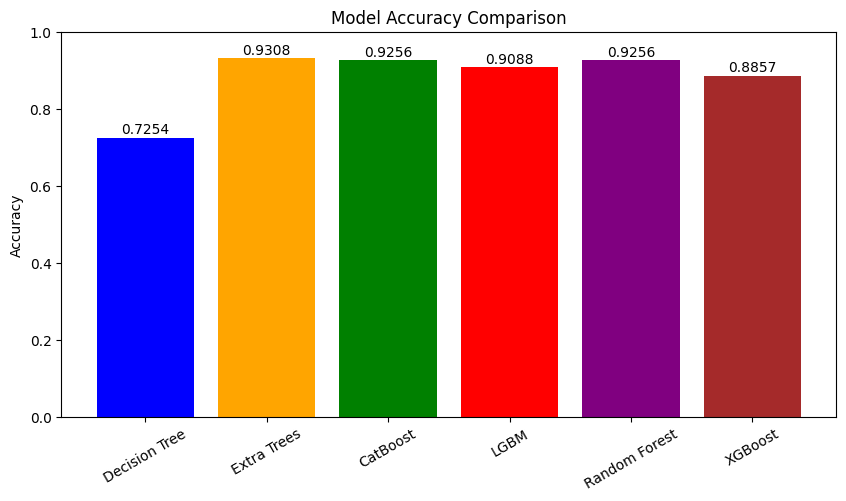

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# T√™n m√¥ h√¨nh v√† ƒë·ªô ch√≠nh x√°c t∆∞∆°ng ·ª©ng
models = ["Decision Tree", "Extra Trees", "CatBoost", "LGBM", "Random Forest", "XGBoost"]
accuracies = [acc_dt, acc_et, acc_cat, acc_lgb, acc_rf, acc_xgb]

# V·∫Ω bi·ªÉu ƒë·ªì c·ªôt d·ªçc
plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)  # Gi·ªõi h·∫°n tr·ª•c y ƒë·ªÉ d·ªÖ quan s√°t

# Hi·ªÉn th·ªã gi√° tr·ªã tr√™n t·ª´ng c·ªôt
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.01, f"{value:.4f}", ha='center')

plt.xticks(rotation=30)  # Xoay nh√£n tr·ª•c x ƒë·ªÉ d·ªÖ ƒë·ªçc
plt.show()


In [13]:
import numpy as np

models = {
    "Random Forest": rf_model,
    "LightGBM": lgb_model,
    "XGBoost": xgb_model,
    "CatBoost": cat_model
}

for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        num_used_features = np.sum(model.feature_importances_ > 0)
        print(f"{name}: {num_used_features} features used")


Random Forest: 630 features used
LightGBM: 407 features used
XGBoost: 416 features used
CatBoost: 365 features used


C:\Users\DO TUAN MINH\AppData\Local\Temp\ipykernel_12224\4262293222.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="viridis")
C:\Users\DO TUAN MINH\AppData\Local\Temp\ipykernel_12224\4262293222.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="viridis")


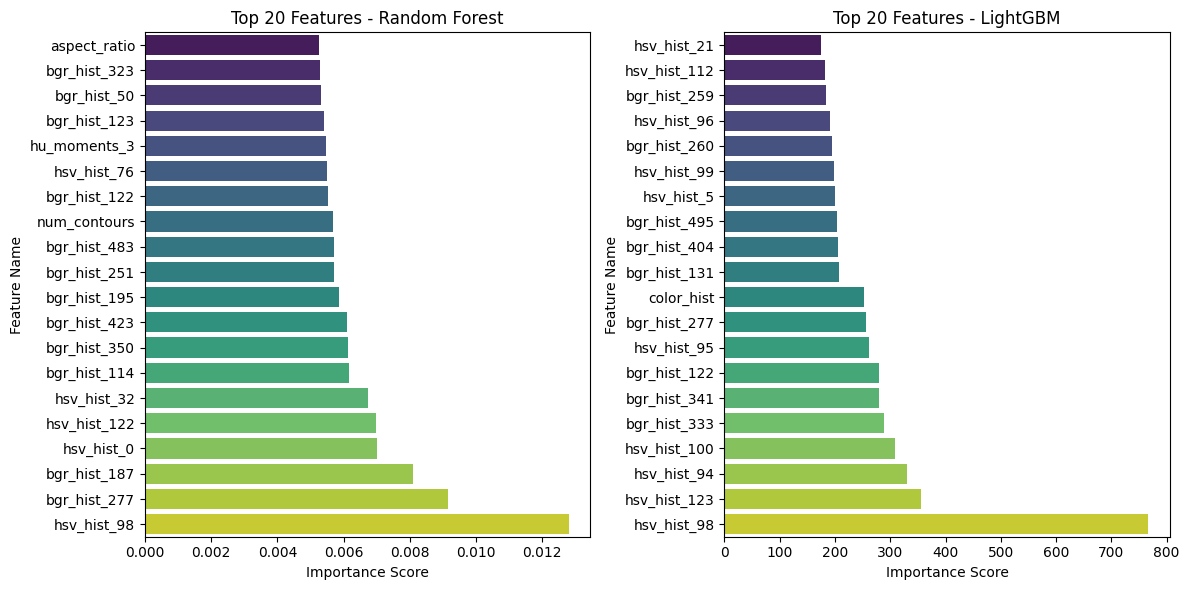

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming these models are trained
models = {
    "Random Forest": rf_model,
    "LightGBM": lgb_model
}

plt.figure(figsize=(12, 6))

for i, (name, model) in enumerate(models.items()):
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
        sorted_idx = np.argsort(feature_importances)[-20:]  # Select top 20
        
        plt.subplot(1, 2, i + 1)
        sns.barplot(x=feature_importances[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="viridis")
        plt.title(f"Top 20 Features - {name}")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature Name")

plt.tight_layout()
plt.show()


In [13]:
for top_n in [100,200, 300,400, 500, 600]:
    sorted_idx = np.argsort(feature_importances)[::-1][:top_n]
    X_train_selected = X_train[:, sorted_idx]
    X_test_selected = X_test[:, sorted_idx]

    model = lgb.LGBMClassifier(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=300,
        reg_alpha=0.1,
        reg_lambda=0.1,
        class_weight='balanced',
        verbosity=-1
    )
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    print(f"LGBM Accuracy v·ªõi {top_n} features: {accuracy_score(y_test, y_pred):.4f}")


LGBM Accuracy v·ªõi 100 features: 0.8857
LGBM Accuracy v·ªõi 200 features: 0.8931
LGBM Accuracy v·ªõi 300 features: 0.8983
LGBM Accuracy v·ªõi 400 features: 0.8962
LGBM Accuracy v·ªõi 500 features: 0.9004
LGBM Accuracy v·ªõi 600 features: 0.9004


In [14]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Train Random Forest ban ƒë·∫ßu
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# L·∫•y feature importance
feature_importances = rf_model.feature_importances_

# Danh s√°ch s·ªë feature ƒë·ªÉ th·ª≠ nghi·ªám
top_n_list = [50, 100, 200, 300, 400, 500]

# L∆∞u k·∫øt qu·∫£  
results = {}

for top_n in top_n_list:
    sorted_idx = np.argsort(feature_importances)[::-1][:top_n]  
    X_train_selected = X_train[:, sorted_idx]  
    X_test_selected = X_test[:, sorted_idx]  
    
    # Train l·∫°i model v·ªõi features m·ªõi
    rf_selected_model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
    rf_selected_model.fit(X_train_selected, y_train)

    # D·ª± ƒëo√°n v√† ƒë√°nh gi√°
    y_pred_rf_selected = rf_selected_model.predict(X_test_selected)
    acc = accuracy_score(y_test, y_pred_rf_selected)
    
    results[top_n] = acc
    print(f"Random Forest Accuracy v·ªõi {top_n} features: {acc:.4f}")

# In ra k·∫øt qu·∫£ t·ªïng h·ª£p
print("üìä K·∫øt qu·∫£ t·ªïng h·ª£p:", results)


Random Forest Accuracy v·ªõi 50 features: 0.8889
Random Forest Accuracy v·ªõi 100 features: 0.9193
Random Forest Accuracy v·ªõi 200 features: 0.9172
Random Forest Accuracy v·ªõi 300 features: 0.9193
Random Forest Accuracy v·ªõi 400 features: 0.9172
Random Forest Accuracy v·ªõi 500 features: 0.9182
üìä K·∫øt qu·∫£ t·ªïng h·ª£p: {50: 0.8888888888888888, 100: 0.9192872117400419, 200: 0.9171907756813418, 300: 0.9192872117400419, 400: 0.9171907756813418, 500: 0.9182389937106918}


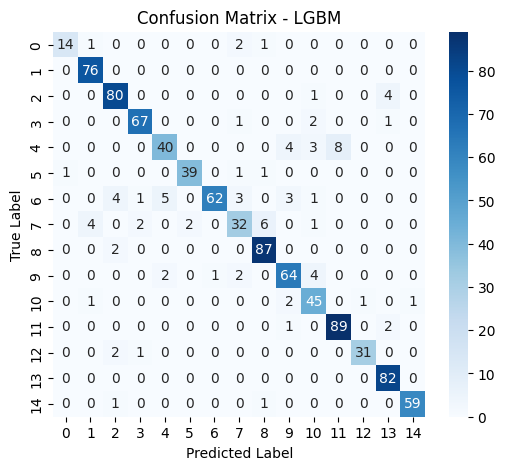

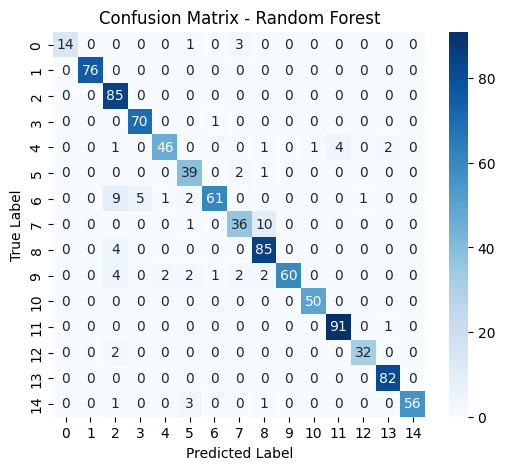

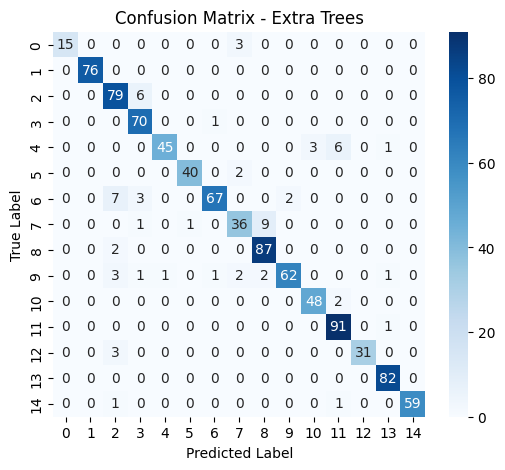

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# H√†m v·∫Ω Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_true), yticklabels=set(y_true))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# V·∫Ω Confusion Matrix cho t·ª´ng m√¥ h√¨nh
plot_confusion_matrix(y_test, y_pred_lgb, "LGBM")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_et, "Extra Trees")
